In [53]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [54]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
    
def get_data_loader(image_type, image_dir='/kaggle/input/s2wdata', image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'A' or 'B'."""
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # resize to 128x128
        transforms.ToTensor()
    ])

    train_path = os.path.join(image_dir, 'train{}'.format(image_type))
    test_path = os.path.join(image_dir, 'test{}'.format(image_type))

    train_dataset = CustomImageDataset(train_path, transform=transform)
    test_dataset = CustomImageDataset(test_path, transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [55]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='A')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='B')

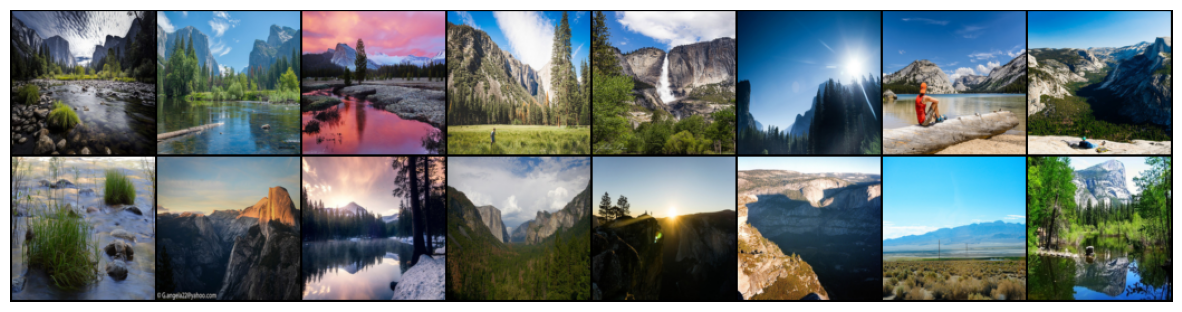

In [56]:
# Helper function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide the axis

# Get some images from dataloader_X
dataiter= iter(dataloader_X)
# Get the next batch of images
images = next(dataiter)

# Show images
fig = plt.figure(figsize=(15, 8))
imshow(torchvision.utils.make_grid(images))
plt.show()


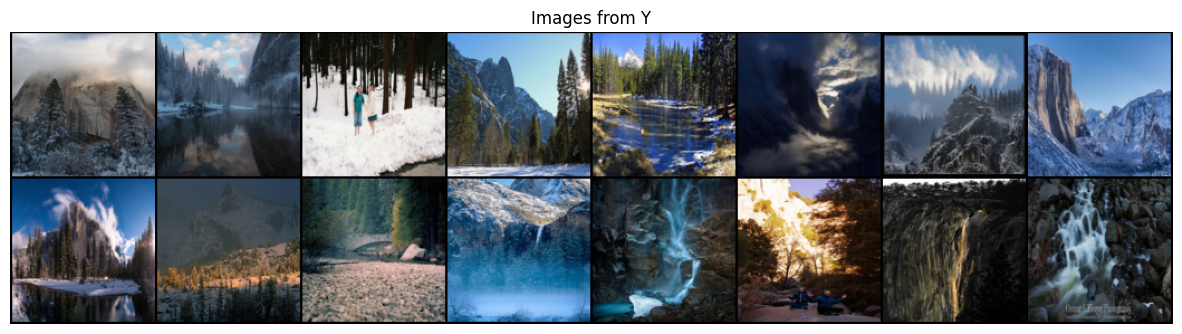

In [57]:
# Get some images from dataloader_Y
dataiter= iter(dataloader_Y)
# Get the next batch of images
images = next(dataiter)

# Show images from Y
fig_Y = plt.figure(figsize=(15, 8))
plt.title('Images from Y')
imshow(torchvision.utils.make_grid(images))
plt.show()

In [58]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0196)
Max:  tensor(0.9373)


In [59]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [60]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9608)
Scaled max:  tensor(0.8745)


In [61]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [62]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        self.layer_4 = conv(conv_dim*4,conv_dim*8,4)
        self.layer_5 = conv(conv_dim*8,1,4,1,batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        
        x = self.layer_5(x)
        return x

In [63]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.layer_1 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        self.layer_2 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.layer_1(x))
        out_2 = x + self.layer_2(out_1)
        
        return out_2

In [64]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [65]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.layer_1 = conv(3,conv_dim,4)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        # 2. Define the resnet part of the generator
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*layers)
        # 3. Define the decoder part of the generator
        self.layer_4 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_5 = deconv(conv_dim*2,conv_dim,4)
        self.layer_6 = deconv(conv_dim,3,4,batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        
        out = self.res_blocks(out)
        
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        
        return out

In [66]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim,n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim,n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [67]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [68]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [69]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)

    
def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

In [70]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [71]:
import torch.nn.functional as F

def real_mse_loss(predictions, targets):
    loss = F.mse_loss(predictions, targets)
    return loss

def fake_mse_loss(predictions, targets):
    loss = F.mse_loss(predictions, targets)
    return loss


In [72]:

def save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, sample_dir='samples_cyclegan'):
    # Set evaluation mode for generators
    G_YtoX.eval()
    G_XtoY.eval()

    # Move fixed inputs to the same device as the models
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fixed_Y = fixed_Y.to(device)
    fixed_X = fixed_X.to(device)

    # Generate samples from fixed_Y to X
    with torch.no_grad():
        fake_X = G_YtoX(fixed_Y)
    
    # Generate samples from fixed_X to Y
    with torch.no_grad():
        fake_Y = G_XtoY(fixed_X)

    # Restore to training mode
    G_YtoX.train()
    G_XtoY.train()

    # Ensure the sample directory exists
    os.makedirs(sample_dir, exist_ok=True)

    # Save images using torchvision
    path_XtoY = os.path.join(sample_dir, f'sample-{epoch:06d}-X-Y.png')
    path_YtoX = os.path.join(sample_dir, f'sample-{epoch:06d}-Y-X.png')
    torchvision.utils.save_image(fake_X, path_XtoY, normalize=True)
    torchvision.utils.save_image(fake_Y, path_YtoX, normalize=True)

In [73]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every = 10
    sample_every = 100
    checkpoint_every = 1000
    
    # Initialize losses list
    losses = []

    # Get iterators for test dataloaders
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling
    fixed_X = next(test_iter_X)
    fixed_Y = next(test_iter_Y)
    fixed_X = scale(fixed_X)  # Assuming scale is a function to normalize the images
    fixed_Y = scale(fixed_Y)

    # Define number of batches per epoch
    batches_per_epoch = min(len(dataloader_X), len(dataloader_Y))

    for epoch in range(1, n_epochs + 1):
        
        # Initialize iterators for each epoch
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)

        for batch_idx in range(1, batches_per_epoch + 1):
            
            # Fetch batches from dataloaders
            images_X = next(iter_X)
            images_Y = next(iter_Y)

            # Scale images to a range -1 to 1
            images_X = scale(images_X)
            images_Y = scale(images_Y)
            
            # Move images to GPU if available
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images_X = images_X.to(device)
            images_Y = images_Y.to(device)

            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================

            # Zero gradients for optimizers
            d_x_optimizer.zero_grad()
            d_y_optimizer.zero_grad()

            # Compute real loss for D_X
            real_D_loss = real_mse_loss(D_X(images_X), torch.ones_like(D_X(images_X)))

            # Generate fake images that look like domain X based on real images in domain Y
            fake_X = G_YtoX(images_Y)
            # Compute the fake loss for D_X
            fake_D_loss = fake_mse_loss(D_X(fake_X.detach()), torch.zeros_like(D_X(fake_X.detach())))

            # Total loss and backprop
            d_x_loss = real_D_loss + fake_D_loss
            d_x_loss.backward()
            d_x_optimizer.step()

            # Compute real loss for D_Y
            real_D_y_loss = real_mse_loss(D_Y(images_Y), torch.ones_like(D_Y(images_Y)))

            # Generate fake images that look like domain Y based on real images in domain X
            fake_Y = G_XtoY(images_X)
            # Compute the fake loss for D_Y
            fake_D_y_loss = fake_mse_loss(D_Y(fake_Y.detach()), torch.zeros_like(D_Y(fake_Y.detach())))

            # Total loss and backprop
            d_y_loss = real_D_y_loss + fake_D_y_loss
            d_y_loss.backward()
            d_y_optimizer.step()

            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================

            # Zero gradients for optimizers
            g_optimizer.zero_grad()

            # Generate fake images that look like domain X based on real images in domain Y
            fake_X = G_YtoX(images_Y)
            out_X = D_X(fake_X)
            g_loss_X = real_mse_loss(out_X, torch.ones_like(out_X))

            # Create reconstructed images
            rec_Y = G_XtoY(fake_X)
            # Compute the cycle consistency loss
            cycle_loss_X = cycle_consistency_loss(images_Y, rec_Y, lambda_weight=10)

            # Generate fake images that look like domain Y based on real images in domain X
            fake_Y = G_XtoY(images_X)
            out_Y = D_Y(fake_Y)
            g_loss_Y = real_mse_loss(out_Y, torch.ones_like(out_Y))

            # Create reconstructed images
            rec_X = G_YtoX(fake_Y)
            # Compute the cycle consistency loss
            cycle_loss_Y = cycle_consistency_loss(images_X, rec_X, lambda_weight=10)

            # Total generator loss and backprop
            g_total_loss = g_loss_X + g_loss_Y + cycle_loss_X + cycle_loss_Y
            g_total_loss.backward()
            g_optimizer.step()

            # Print the log info
            if epoch % print_every == 0 and batch_idx == 1:
                # Append losses
                losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
                print('Epoch [{}/{}], Batch [{}/{}], d_X_loss: {:.4f}, d_Y_loss: {:.4f}, g_total_loss: {:.4f}'
                      .format(epoch, n_epochs, batch_idx, batches_per_epoch, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

        # Sample and save images
        if epoch % sample_every == 0:
            G_YtoX.eval()  # Set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY)
            G_YtoX.train()
            G_XtoY.train()

        # Save checkpoints
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [74]:
n_epochs = 100 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [10/100], Batch [1/61], d_X_loss: 1.0182, d_Y_loss: 0.5357, g_total_loss: 6.1727
Epoch [20/100], Batch [1/61], d_X_loss: 0.3092, d_Y_loss: 0.3142, g_total_loss: 5.0854
Epoch [30/100], Batch [1/61], d_X_loss: 0.1929, d_Y_loss: 0.2701, g_total_loss: 4.3934
Epoch [40/100], Batch [1/61], d_X_loss: 0.1820, d_Y_loss: 0.3363, g_total_loss: 5.0956
Epoch [50/100], Batch [1/61], d_X_loss: 0.3597, d_Y_loss: 0.0404, g_total_loss: 5.0070
Epoch [60/100], Batch [1/61], d_X_loss: 0.8878, d_Y_loss: 0.1731, g_total_loss: 3.6408
Epoch [70/100], Batch [1/61], d_X_loss: 0.1357, d_Y_loss: 0.1868, g_total_loss: 4.3126
Epoch [80/100], Batch [1/61], d_X_loss: 0.0825, d_Y_loss: 0.0483, g_total_loss: 4.2717
Epoch [90/100], Batch [1/61], d_X_loss: 0.2232, d_Y_loss: 0.1089, g_total_loss: 4.3923
Epoch [100/100], Batch [1/61], d_X_loss: 0.2091, d_Y_loss: 0.0964, g_total_loss: 5.6422


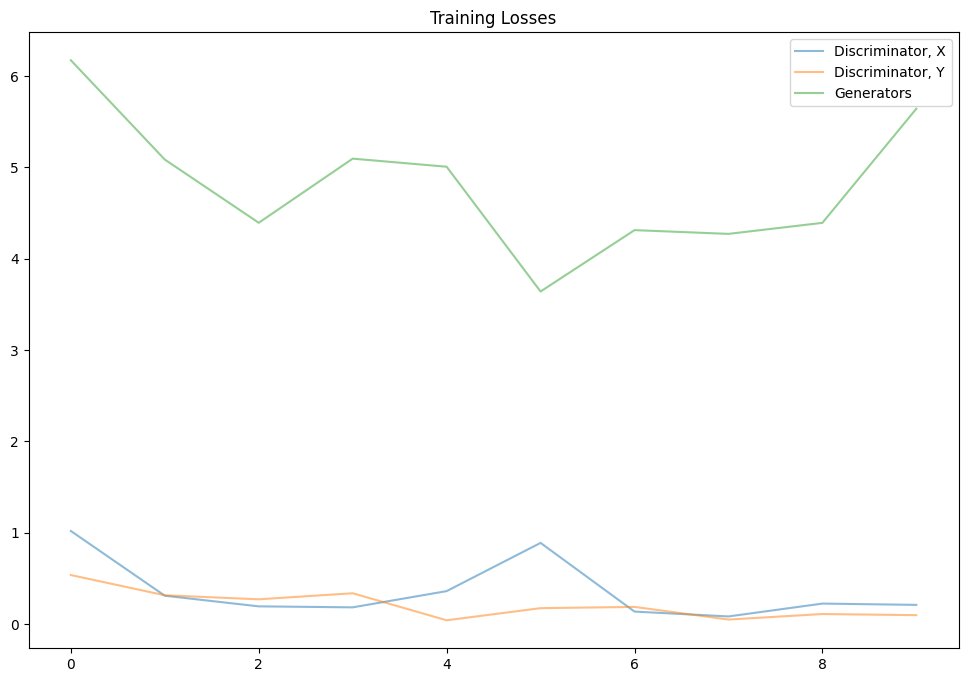

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

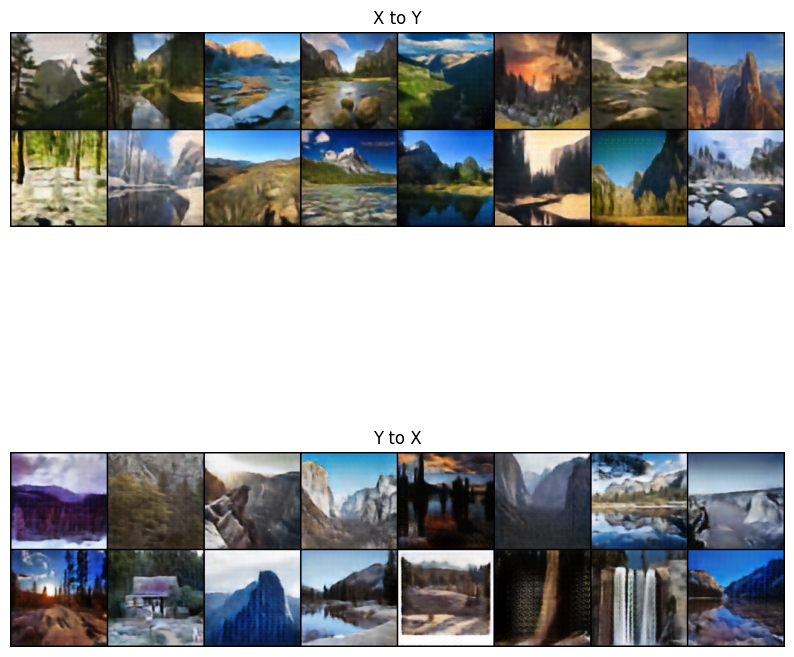

In [76]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

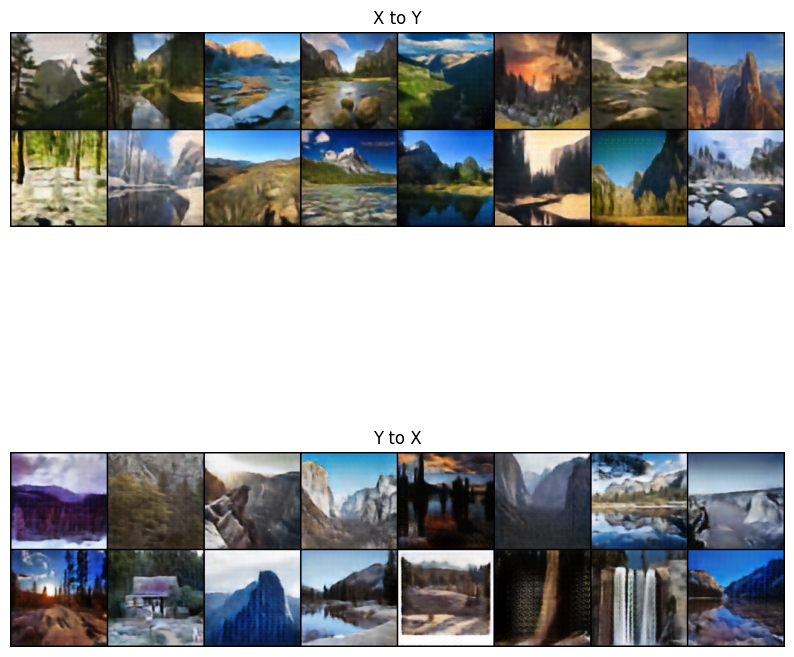

In [77]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')
